In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


2022-03-10 16:01:25.880099: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-10 16:01:25.880120: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-03-10 16:01:27.256791: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 16:01:27.257488: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-10 16:01:27.257543: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.s

## create model

In [2]:
import os, json, importlib
import tqdm

class TestResult():
    
    def __init__(self, ini_file):
        
        with open( ini_file,"r") as jfile:
            config = json.load( jfile)
        self.config = config
        
        tf_model = importlib.import_module(config["cvae_model"]["use_model"])
        self.model = tf_model.CVAE( config["cvae_model"])

        wfile = ini_file[:-5]+"/tmp_weights.h5"
        if os.path.isfile(wfile):
            self.model.built = True
            weightfile = wfile
            print(f"Read weights\t:\t{weightfile}")
            self.model.load_weights( weightfile)

        self.waveform_module = importlib.import_module(config["waveform_model"]["use_model"])
        self.wf = self.waveform_module.waveform( config["waveform_model"]["parameter"])
        print( f"read valid data")
        self.wf.readdata( [ini_file[:-5]+".valid.h5"])
    
        
    def preprocessing_batch(self, n=1, data=None):
        wf = self.wf
        #print(len(wf.data['X']))
        if not hasattr( self, 'preprocessing_scaler'):
            self.preprocessing_scaler = self.waveform_module.preprocessing_scaler( wf, self.config['preprocessing'])
        if data is None:
            data = wf.random_batch(n)
        self.waveform_module.preprocessing_batch( data, scaler=self.preprocessing_scaler)
        return data


In [3]:
mx_result = TestResult( "../build/new_mixnormal_o3a_psd.json")

2022-03-10 16:01:40.123685: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Create CVAE
net[ASD] , {'shape': [513, 1]}
net[Y] , {'shape': [513, 2]}
net[X] , {'shape': 5}
Model: "E1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ASD (InputLayer)               [(None, 513, 1)]     0           []                               
                                                                                                  
 f_ASD (Flatten)                (None, 513)          0           ['ASD[0][0]']                    
                                                                                                  
 FC1P (Dense)                   (None, 2048)         1052672     ['f_ASD[0][0]']                  
                                                                                                  
 FC2P (Dense)                   (None, 2048)         4196352     ['FC1P[0][0]']                   
   

2022-03-10 16:01:40.404338: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


net[ASD] , {'shape': [513, 1]}
net[Y] , {'shape': [513, 2]}
Model: "E2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ASD (InputLayer)               [(None, 513, 1)]     0           []                               
                                                                                                  
 f_ASD (Flatten)                (None, 513)          0           ['ASD[0][0]']                    
                                                                                                  
 FC1P (Dense)                   (None, 2048)         1052672     ['f_ASD[0][0]']                  
                                                                                                  
 FC2P (Dense)                   (None, 2048)         4196352     ['FC1P[0][0]']                   
                                     

0it [00:00, ?it/s]


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '../build/new_mixnormal_o3a_psd.valid.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [5]:
def ppplot(model, n, nsample):

    count_list = []
    for i in range(n):
        data = model.preprocessing_batch(1)
        strain = model.model.test( data, nsample).numpy()
        for idx, x in enumerate(data['X'][0]):
            count = np.count_nonzero( strain[:,idx] < x)
            count_list.append(count/nsample)
    return np.asarray(count_list).reshape(-1,len(data['X'][0]))

In [6]:
plist = ppplot( nm_result, 1024, 10000)

NameError: name 'nm_result' is not defined

NameError: name 'plist' is not defined

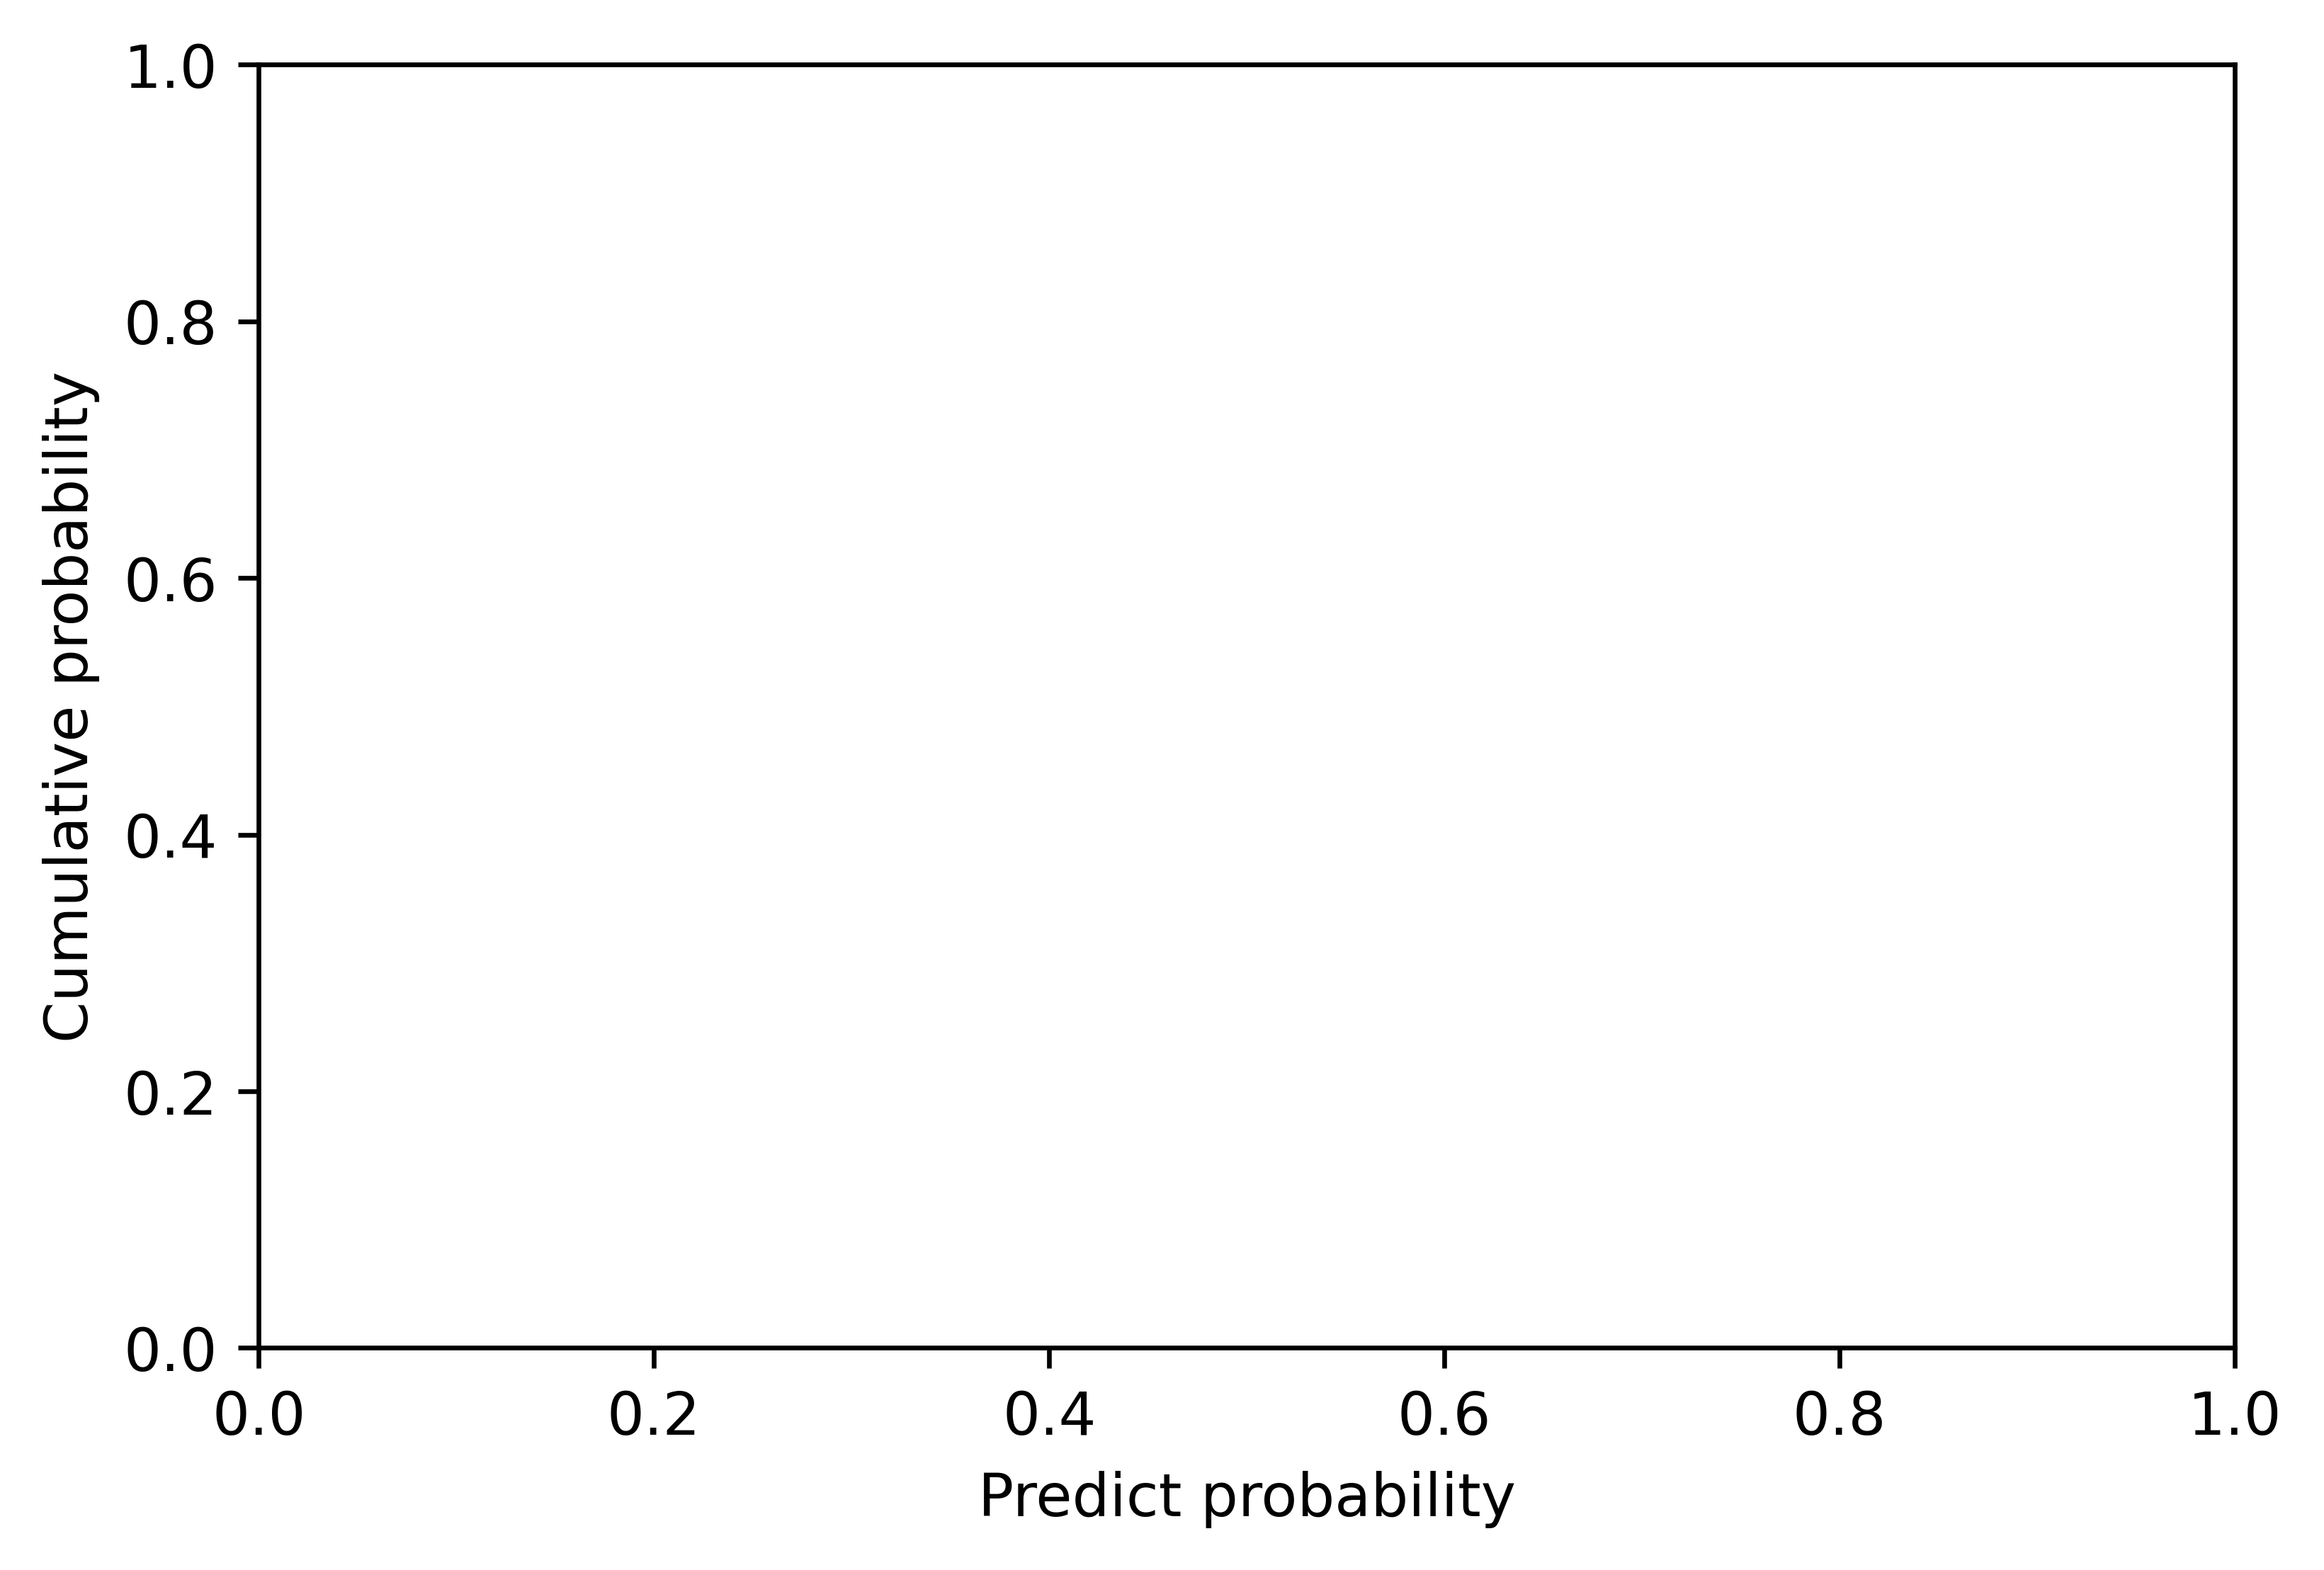

In [7]:
plt.rc('figure', facecolor='w')

title = ['$q$','$\mathcal {M}$','$\phi_0$','$t_c$','$d_L$']


plt.figure(dpi=600)
plt.xlabel('Predict probability')
plt.ylabel('Cumulative probability')
for k in range(len(plist[0])):
    P_series = np.sort(plist[:,k])
    cumulative = np.linspace(1,len(P_series),len(P_series))/len(P_series)

    plt.step(P_series,cumulative,label=title[k], where='post')
        
plt.legend()
plt.plot([0,1],[0,1],color='black')
plt.ylim(0,1)
plt.xlim(0,1)
#plt.title("PPplot (CVAE)")
plt.savefig('ppplot.png')
plt.show()

In [8]:
import h5py as h5
def readstrain(fname):
    with h5.File(fname,"r") as f:
        data = f["/samples"][()]
        print( f["/log_bayes_factor"][()])
    return data

name = 'new_mixnormal_o3a_psd'

peflist = []
stflist = []
daflist = []
j = 0
for i in range(512):
    pefile = "../build/{}.pe{:03d}.h5".format(name,i)
    dafile = "./dynesty_{0}.pe{1:03d}/dynesty_{0}.pe{1:03d}_samples.dat".format(name,i)
    h5file = "./dynesty_{0}.pe{1:03d}/dynesty_{0}.pe{1:03d}_result.hdf5".format(name,i)
    if os.path.exists(h5file):
        peflist.append( pefile)
        stflist.append( h5file)
        daflist.append( dafile)
        #print(gps[i], j)
        j+=1


In [9]:
wf_o3 = mx_result.waveform_module.waveform( mx_result.config["waveform_model"]["parameter"])
wf_o3.readdata( peflist)


NameError: name 'mx_result' is not defined

In [10]:
import scipy
from scipy.spatial import KDTree

def KLdivergence(s1, s2, k=1):
    """ KL-Divergence estimator using scipy's KDTree
        s1: (N_1,D) Sample drawn from distribution P
        s2: (N_2,D) Sample drawn from distribution Q
        k: Number of neighbours considered (default 1)
        return: estimated D(P|Q)
    """
    #verify_sample_shapes(s1, s2, k)

    n, m = len(s1), len(s2)
    d = float(s1.shape[1])
    D = np.log(m / (n - 1))

    nu_d,  nu_i   = KDTree(s2).query(s1, k)
    rho_d, rhio_i = KDTree(s1).query(s1, k+1)
    
    while np.any(rho_d[:,-1] ==0):
        print( 'k too small %g'%k)
        k += 10
        nu_d,  nu_i   = KDTree(s2).query(s1, k)
        rho_d, rhio_i = KDTree(s1).query(s1, k+1)

    # KTree.query returns different shape in k==1 vs k > 1
    if k > 1:
        D += (d/n)*np.sum(np.log(nu_d[::, -1]/rho_d[::, -1]))
    else:
        D += (d/n)*np.sum(np.log(nu_d/rho_d[::, -1]))

    return D



for i in range(5):
    print( KLdivergence( strain[:,i].reshape(-1,1), mstrain[:,i].reshape(-1,1), k=500))


NameError: name 'strain' is not defined

In [11]:
mstrain_list = []
dstrain_list = []
nstrain_list = []
for num in trange(len(daflist)):
    dstrain = readstrain( stflist[num])
    #dstrain = np.loadtxt( daflist[num], dtype=float, skiprows=1)
    #dstrain = mx_result.preprocessing_scaler['X'].transform( dstrain)

    dstrain_list.append( dstrain)
    mstrain_list.append( get_data(num, result=mx_result, ddata=ddata, size=len(dstrain)) )
    nstrain_list.append( get_data(num, result=nm_result, ddata=ddata, size=len(dstrain)) )
    #print( KLdivergence( dstrain_list[0][:,1:2], mstrain_list[0][:,1:2], 10))

NameError: name 'trange' is not defined

In [12]:

with ipp.Cluster() as rc:
    # get a view on the cluster
    view = rc.load_balanced_view()
    # submit the tasks
    asyncresult = view.map_async( calculate_kl, dstrain_list, mstrain_list )
    # wait interactively for results
    asyncresult.wait_interactive()
    # retrieve actual results
    result = asyncresult.get()

kl_arr_mx = np.asarray( result)


NameError: name 'ipp' is not defined

In [13]:
def plot_kl( kl_arr):
    #title = ['$q$','$M$','$\phi_0$','$t_c$','$d_L$']
    plt.figure(dpi=600)
    #print( kl_arr)
    for i in range(5):
        logbins = np.geomspace(np.max([0.0001,kl_arr[:,i].min()]), kl_arr[:,i].max(), 25)
        plt.hist(kl_arr[:,i],bins=logbins,histtype='step',label=title[i],density=True)
    plt.xscale('log')
    plt.yscale('log')
    #plt.xlim(0.1,10)
    plt.ylabel("$p(\operatorname{D}_{KL})$")
    plt.xlabel("$\operatorname{D}_{KL}$")
    plt.legend()
    plt.title('KL div(cvae-dynesty)')
    plt.savefig('kldiv_original.png')
    plt.show()
plot_kl( kl_arr_mx)


NameError: name 'kl_arr_mx' is not defined

In [14]:
loss = np.loadtxt('/home/hance/76/Code/build/new_mixnormal_o3a_psd/loss.txt')
plt.figure(dpi=360)
ltitle = ['$\log p(x)$','D$_\mathrm{KL}}$','$\log p(x)$ validation','D$_\mathrm{KL}}$ validation']
for ii in range(4):
    plt.plot(np.arange(len(loss[2000:]))*512,loss[2000:,ii], label=ltitle[ii])
plt.xscale('log')
plt.grid()
plt.legend()
plt.xlabel('generation')
plt.ylabel('loss function')
plt.savefig('loss_o3a.png')
plt.show()

OSError: /home/hance/76/Code/build/new_mixnormal_o3a_psd/loss.txt not found.